<a href="https://colab.research.google.com/github/HauwaUmar/Stock-prediction-using-neural-network-models/blob/main/lstm_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached yfinance-0.2.10-py2.py3-none-any.whl (59 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 68.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beauti

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import datetime

In [7]:
now = datetime.datetime.now().strftime("%Y-%m-%d")
pfe = yf.download("PFE", start="2014-07-10", end=now)
pfe

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-10,28.235294,28.500950,28.064516,28.462997,20.729725,21200367
2014-07-11,28.500950,28.576851,28.273245,28.529411,20.778097,19350913
2014-07-14,28.643265,28.776091,28.557875,28.690702,20.895567,21589820
2014-07-15,28.652752,29.051233,28.652752,28.851992,21.013031,32000494
2014-07-16,28.946869,29.383303,28.814041,29.373814,21.393078,37260165
...,...,...,...,...,...,...
2023-02-02,43.630001,44.459999,43.500000,44.340000,44.340000,35279200
2023-02-03,44.360001,44.389999,43.880001,44.060001,44.060001,23731000
2023-02-06,44.189999,44.299999,43.730000,43.759998,43.759998,18071200


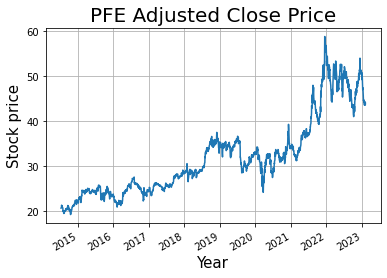

In [8]:

# Plot Adjusted Close price

pfe['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(16, 8)})
plt.title('PFE Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

In [9]:
pfe_adj = pfe[['Adj Close']]

In [10]:

# Convert DataFrame to numpy array
pfe_adj_arr = pfe_adj.values

# Find number of rows to train model on (80% of data set) 
training_data_len = int(0.8*len(pfe_adj))

training_data_len

1729

In [11]:
train = pfe_adj_arr[0:training_data_len, :]

In [12]:

# Normalise the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)

train_scaled

array([[0.07102421],
       [0.07344295],
       [0.07931674],
       ...,
       [0.92262704],
       [0.91225549],
       [0.92592731]])

In [13]:
train_scaled.shape

(1729, 1)

In [14]:
# Creating a data structure with 60 time-steps and 1 output

# Split data into X_train and y_train data sets
X_train = []
y_train = []
# Creating a data structure with 60 time-steps and 1 output
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i:i+1, 0])  
    if i <= 61:     # 60 days for first pass, 61 for second
      print(X_train)
      print(y_train)
      print()

[array([0.07102421, 0.07344295, 0.07931674, 0.08519025, 0.10419358,
       0.09002725, 0.09624668, 0.08311733, 0.08795443, 0.08449909,
       0.0827718 , 0.07758897, 0.07447964, 0.06169526, 0.05437562,
       0.03485604, 0.04043332, 0.03659887, 0.02474752, 0.02021656,
       0.01185088, 0.02230818, 0.01917081, 0.01324522, 0.01777656,
       0.03590208, 0.0327649 , 0.03973596, 0.04322172, 0.0414786 ,
       0.03903897, 0.04252426, 0.04217606, 0.05263269, 0.06239243,
       0.05855846, 0.05890705, 0.05437562, 0.05925535, 0.05820949,
       0.06796943, 0.05925535, 0.05333015, 0.0606496 , 0.06727245,
       0.0603013 , 0.07738059, 0.08191201, 0.09236893, 0.10038565,
       0.09411157, 0.08644316, 0.08191201, 0.09097439, 0.0794721 ,
       0.07040953, 0.07215218, 0.06518112, 0.05054146, 0.04740437])]
[array([0.05298127])]

[array([0.07102421, 0.07344295, 0.07931674, 0.08519025, 0.10419358,
       0.09002725, 0.09624668, 0.08311733, 0.08795443, 0.08449909,
       0.0827718 , 0.07758897, 0.07

In [15]:
# Convert X_train and y_train to numpy arrays for training LSTM model
X_train, y_train = np.array(X_train), np.array(y_train)

In [16]:
# Reshape the data as LSTM expects 3-D data (samples, time steps, features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape
     

(1669, 60, 1)

In [17]:

# Build model - LSTM with 50 neurons and 4 hidden layers  

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, activation='tanh'))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 200, batch_size = 64)

Epoch 1/200
27/27 [==============================] - 13s 164ms/step - loss: 0.0482
Epoch 2/200
27/27 [==============================] - 5s 203ms/step - loss: 0.0078
Epoch 3/200
27/27 [==============================] - 4s 159ms/step - loss: 0.0070
Epoch 4/200
27/27 [==============================] - 4s 159ms/step - loss: 0.0060
Epoch 5/200
27/27 [==============================] - 5s 203ms/step - loss: 0.0059
Epoch 6/200
27/27 [==============================] - 4s 161ms/step - loss: 0.0060
Epoch 7/200
27/27 [==============================] - 5s 168ms/step - loss: 0.0054
Epoch 8/200
27/27 [==============================] - 5s 188ms/step - loss: 0.0050
Epoch 9/200
27/27 [==============================] - 4s 161ms/step - loss: 0.0051
Epoch 10/200
27/27 [==============================] - 5s 200ms/step - loss: 0.0049
Epoch 11/200
27/27 [==============================] - 4s 159ms/step - loss: 0.0052
Epoch 12/200
27/27 [==============================] - 4s 162ms/step - loss: 0.0049
Epoch 13/200

In [18]:
test = pfe_adj_arr[training_data_len: , :]

In [19]:
test.shape

(433, 1)

In [20]:

# Predicting 253 values, using past 60 from the train data
inputs = pfe_adj_arr[len(pfe_adj_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
     

In [21]:
# Create data sets X_test and y_test
X_test = []
y_test = pfe_adj_arr[training_data_len:, :]
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

In [22]:
# Convert data to numpy array
X_test = np.array(X_test)

In [23]:
# Reshape data to be 3-D
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [24]:

print(X_test.shape)

(433, 60, 1)


In [25]:
# We want predictions to contain same values as y_test data set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

14/14 [==============================] - 2s 31ms/step


In [26]:
predictions.shape

(433, 1)

In [27]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)  
rmse

2.6344023477673257

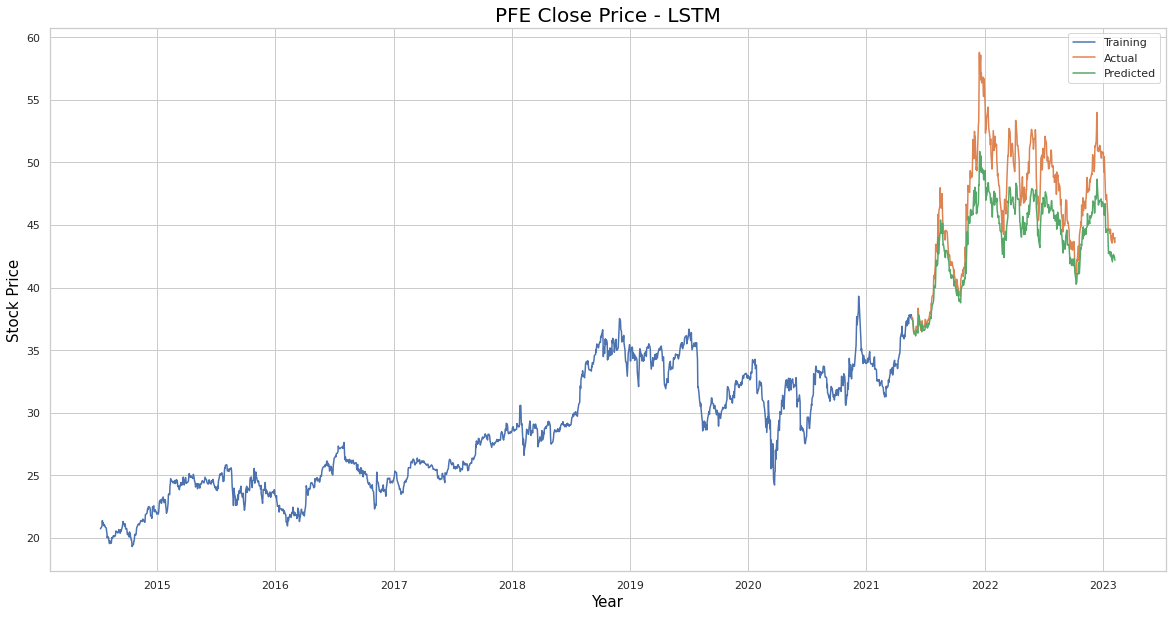

In [29]:
# Plot predicted vs actual values  
train = pfe_adj[:training_data_len]
test = pfe_adj[training_data_len:]
test['Predictions'] = predictions

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("PFE Close Price - LSTM", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

In [30]:
test

,Adj Close,Predictions
Date,,
2021-05-21,37.666607,37.463070
2021-05-24,37.534618,37.378540
2021-05-25,37.082047,37.237461
2021-05-26,36.695477,36.874428
2021-05-27,36.440910,36.525234
...,...,...
2023-02-02,44.340000,42.391304
2023-02-03,44.060001,42.644157
2023-02-06,43.759998,42.495907
